In [21]:
import os
from tqdm import tqdm

import torch

from torch_geometric.data import Data, InMemoryDataset
from torch_geometric.loader import DataLoader

import pandas as pd

In [8]:
class LandmarksToGraph(InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None):
        super(LandmarksToGraph, self).__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def processed_file_names(self):
        return 'data.pt'

    def process(self):
        src = os.path.join(self.raw_dir, 'train')
        edges_path = os.path.join(self.raw_dir, 'EDGES.txt')
        
        '''
        def make_undirected_graph_with_self_loops(edges_path):
            df_edge = pd.read_csv(edges_path, delimiter=',', header=None)
            edge_idx = torch.tensor(df_edge.to_numpy(), dtype=torch.int64)

            edge_index = edge_idx.tolist()
            for item in edge_index:
                x, y = item
                item_pair = [y, x]
                if item_pair in edge_index:
                    continue
                else:
                    edge_index.append(item_pair)

            # Add self-loop
            for i in range(468):
                edge_index.append([i, i])
            
            return torch.tensor(edge_index, dtype=torch.int64).T

        edge_idx = make_undirected_graph_with_self_loops(edges_path)
        '''

        df_edge = pd.read_csv(edges_path, delimiter=',', header=None)
        edge_idx = torch.tensor(df_edge.to_numpy().transpose(), dtype=torch.int64)
        
        data_list = list()
        for idx, category in tqdm(enumerate(os.listdir(src))):
            file_path = os.path.join(src, category)
            
            for file in os.listdir(file_path):
                filename_path = os.path.join(file_path, file)
                
                df_file = pd.read_csv(filename_path, delimiter=',', header=None)
                
                df_label = idx
                
                # df_edge = pd.read_csv(edges_path, delimiter=',', header=None)
                            
                x = torch.tensor(df_file.to_numpy(), dtype=torch.float)
                # edge_idx = torch.tensor(df_edge.to_numpy().transpose(), dtype=torch.int64)
                
                y = torch.tensor(df_label, dtype=torch.int64)
                graph = Data(x=x, edge_index=edge_idx, y=y)
                data_list.append(graph)

        # Store the processed data
        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])

dataset = LandmarksToGraph(root='dataset')

Processing...
7it [02:35, 22.22s/it]
Done!


In [55]:
data = dataset[0]

# Print information about the dataset
print(f'Dataset: {dataset}')
print('-------------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {data.x.shape[0]}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

# Print information about the graph
print(f'\nGraph:')
print('------')
print(f'Edges are directed?: {data.is_directed()}')
print(f'Graph has isolated nodes?: {data.has_isolated_nodes()}')
print(f'Graph has self.loops?: {data.has_self_loops()}')

Dataset: LandmarksToGraph(26622)
-------------------
Number of graphs: 26622
Number of nodes: 468
Number of features: 3
Number of classes: 7

Graph:
------
Edges are directed?: True
Graph has isolated nodes?: False
Graph has self.loops?: False


In [22]:
n = (len(dataset) + 9) // 10
print(f"n: {n}")
print(f"2*n: {2*n}")

torch.manual_seed(12345)
dataset = dataset.shuffle()
n = (len(dataset) + 9) // 10
test_dataset = dataset[:n]
val_dataset = dataset[n:2 * n]
train_dataset = dataset[2 * n:]

test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=True)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

n: 2663
2*n: 5326


## Train GCNConv

In [23]:
from torch_geometric.nn import GCNConv
from torch.nn import Linear
from torch_geometric.nn import global_mean_pool

import torch.nn.functional as F

In [24]:
class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(dataset.num_features, 64)
        self.conv2 = GCNConv(64, 32)
        self.lin = Linear(32, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)

        x = global_mean_pool(x, batch) # output: [batch, hidden_channels]

        x = self.lin(x)

        return x       
        

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN().to(device)

print(model)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)

GCN(
  (conv1): GCNConv(3, 64)
  (conv2): GCNConv(64, 32)
  (lin): Linear(in_features=32, out_features=7, bias=True)
)


In [27]:
def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
        loss = criterion(out, data.y)  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.

def test(loader):
     model.eval()

     correct = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
         data = data.to(device)
         out = model(data.x, data.edge_index, data.batch)  
         pred = out.argmax(dim=1)  # Use the class with highest probability.
         correct += int((pred == data.y).sum())  # Check against ground-truth labels.
     return correct / len(loader.dataset)  # Derive ratio of correct predictions.


train_accuracy = list()
test_accuracy = list()
for epoch in range(1, 171):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    train_accuracy.append(train_acc)
    test_accuracy.append(test_acc)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch: 001, Train Acc: 0.2599, Test Acc: 0.2546
Epoch: 002, Train Acc: 0.2599, Test Acc: 0.2546
Epoch: 003, Train Acc: 0.2599, Test Acc: 0.2546
Epoch: 004, Train Acc: 0.2599, Test Acc: 0.2546
Epoch: 005, Train Acc: 0.2599, Test Acc: 0.2546
Epoch: 006, Train Acc: 0.2599, Test Acc: 0.2546
Epoch: 007, Train Acc: 0.2600, Test Acc: 0.2572
Epoch: 008, Train Acc: 0.2600, Test Acc: 0.2550
Epoch: 009, Train Acc: 0.2600, Test Acc: 0.2554
Epoch: 010, Train Acc: 0.2600, Test Acc: 0.2554
Epoch: 011, Train Acc: 0.2601, Test Acc: 0.2561
Epoch: 012, Train Acc: 0.2602, Test Acc: 0.2550
Epoch: 013, Train Acc: 0.2608, Test Acc: 0.2580
Epoch: 014, Train Acc: 0.2614, Test Acc: 0.2565
Epoch: 015, Train Acc: 0.2665, Test Acc: 0.2599
Epoch: 016, Train Acc: 0.2604, Test Acc: 0.2550
Epoch: 017, Train Acc: 0.2725, Test Acc: 0.2670
Epoch: 018, Train Acc: 0.2705, Test Acc: 0.2602
Epoch: 019, Train Acc: 0.2675, Test Acc: 0.2591
Epoch: 020, Train Acc: 0.2824, Test Acc: 0.2760
Epoch: 021, Train Acc: 0.2697, Test Acc:

[]

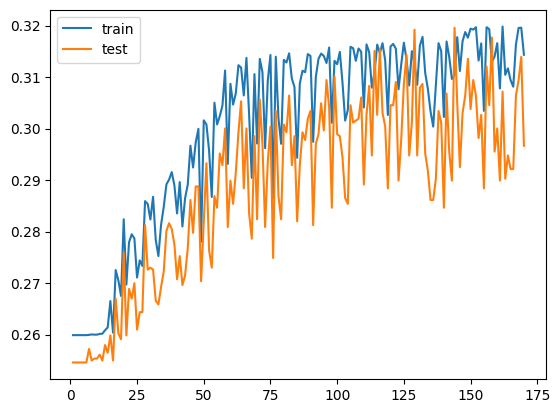

In [30]:
# Plotting
import matplotlib.pyplot as plt
epochs = 170
epoch = [i for i in range(1, epochs+1)]
plt.plot(epoch, train_accuracy, label='train')
plt.plot(epoch, test_accuracy, label='test')
plt.legend()
plt.plot()

## Train GraphConv

In [33]:
from torch_geometric.nn import GraphConv

class GNN(torch.nn.Module):
    def __init__(self):
        super(GNN, self).__init__()
        self.conv1 = GraphConv(dataset.num_features, 128)
        self.conv2 = GraphConv(128, 64)
        self.lin = Linear(64, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)

        x = global_mean_pool(x, batch)

        x = self.lin(x)
        return x

In [34]:
model = GNN().to(device)
print(model)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

GNN(
  (conv1): GraphConv(3, 128)
  (conv2): GraphConv(128, 64)
  (lin): Linear(in_features=64, out_features=7, bias=True)
)


In [35]:
def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
        loss = criterion(out, data.y)  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.

def test(loader):
     model.eval()

     correct = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
         data = data.to(device)
         out = model(data.x, data.edge_index, data.batch)  
         pred = out.argmax(dim=1)  # Use the class with highest probability.
         correct += int((pred == data.y).sum())  # Check against ground-truth labels.
     return correct / len(loader.dataset)  # Derive ratio of correct predictions.


train_accuracy = list()
test_accuracy = list()
for epoch in range(1, 171):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    train_accuracy.append(train_acc)
    test_accuracy.append(test_acc)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch: 001, Train Acc: 0.2595, Test Acc: 0.2535
Epoch: 002, Train Acc: 0.2595, Test Acc: 0.2535
Epoch: 003, Train Acc: 0.2596, Test Acc: 0.2550
Epoch: 004, Train Acc: 0.2609, Test Acc: 0.2554
Epoch: 005, Train Acc: 0.2616, Test Acc: 0.2569
Epoch: 006, Train Acc: 0.2599, Test Acc: 0.2546
Epoch: 007, Train Acc: 0.2840, Test Acc: 0.2775
Epoch: 008, Train Acc: 0.2662, Test Acc: 0.2632
Epoch: 009, Train Acc: 0.2934, Test Acc: 0.2888
Epoch: 010, Train Acc: 0.2612, Test Acc: 0.2557
Epoch: 011, Train Acc: 0.2682, Test Acc: 0.2640
Epoch: 012, Train Acc: 0.2685, Test Acc: 0.2644
Epoch: 013, Train Acc: 0.2691, Test Acc: 0.2651
Epoch: 014, Train Acc: 0.2672, Test Acc: 0.2625
Epoch: 015, Train Acc: 0.2922, Test Acc: 0.2801
Epoch: 016, Train Acc: 0.2655, Test Acc: 0.2625
Epoch: 017, Train Acc: 0.2762, Test Acc: 0.2722
Epoch: 018, Train Acc: 0.2740, Test Acc: 0.2685
Epoch: 019, Train Acc: 0.3260, Test Acc: 0.3109
Epoch: 020, Train Acc: 0.3056, Test Acc: 0.3004
Epoch: 021, Train Acc: 0.3033, Test Acc:

[]

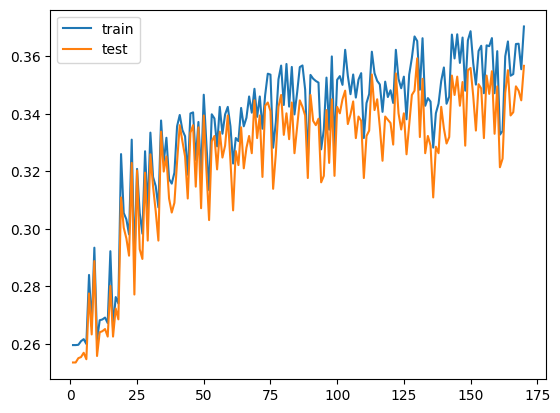

In [36]:
# Plotting
import matplotlib.pyplot as plt
epochs = 170
epoch = [i for i in range(1, epochs+1)]
plt.plot(epoch, train_accuracy, label='train')
plt.plot(epoch, test_accuracy, label='test')
plt.legend()
plt.plot()

## Train GraphSAGE

In [45]:
from torch_geometric.nn import SAGEConv
from torch_geometric.nn import global_mean_pool

class GraphSAGE(torch.nn.Module):
    """GraphSAGE"""
    def __init__(self, dim_in, dim_h, dim_out):
        super(GraphSAGE, self).__init__()
        self.sage1 = SAGEConv(dataset.num_features, dim_h)
        self.sage2 = SAGEConv(dim_h, dim_out)
        self.lin = Linear(dim_out, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        h = self.sage1(x, edge_index)
        h = torch.relu(h)
        h = self.sage2(h, edge_index)

        h = global_mean_pool(h, batch)

        h = self.lin(h)

        return h

In [46]:
model = GraphSAGE(dataset.num_features, 128, 64).to(device)
print(model)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

GraphSAGE(
  (sage1): SAGEConv(3, 128, aggr=mean)
  (sage2): SAGEConv(128, 64, aggr=mean)
  (lin): Linear(in_features=64, out_features=7, bias=True)
)


In [47]:
def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
        loss = criterion(out, data.y)  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.

def test(loader):
     model.eval()

     correct = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
         data = data.to(device)
         out = model(data.x, data.edge_index, data.batch)  
         pred = out.argmax(dim=1)  # Use the class with highest probability.
         correct += int((pred == data.y).sum())  # Check against ground-truth labels.
     return correct / len(loader.dataset)  # Derive ratio of correct predictions.


train_accuracy = list()
test_accuracy = list()
for epoch in range(1, 201):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    train_accuracy.append(train_acc)
    test_accuracy.append(test_acc)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch: 001, Train Acc: 0.2599, Test Acc: 0.2546
Epoch: 002, Train Acc: 0.2705, Test Acc: 0.2644
Epoch: 003, Train Acc: 0.2613, Test Acc: 0.2550
Epoch: 004, Train Acc: 0.2720, Test Acc: 0.2614
Epoch: 005, Train Acc: 0.2759, Test Acc: 0.2674
Epoch: 006, Train Acc: 0.2701, Test Acc: 0.2610
Epoch: 007, Train Acc: 0.2866, Test Acc: 0.2809
Epoch: 008, Train Acc: 0.2910, Test Acc: 0.2783
Epoch: 009, Train Acc: 0.2967, Test Acc: 0.2903
Epoch: 010, Train Acc: 0.2879, Test Acc: 0.2745
Epoch: 011, Train Acc: 0.2955, Test Acc: 0.2895
Epoch: 012, Train Acc: 0.3095, Test Acc: 0.2989
Epoch: 013, Train Acc: 0.2973, Test Acc: 0.2846
Epoch: 014, Train Acc: 0.3215, Test Acc: 0.3075
Epoch: 015, Train Acc: 0.3088, Test Acc: 0.3143
Epoch: 016, Train Acc: 0.3178, Test Acc: 0.3132
Epoch: 017, Train Acc: 0.3158, Test Acc: 0.2944
Epoch: 018, Train Acc: 0.3191, Test Acc: 0.3244
Epoch: 019, Train Acc: 0.3220, Test Acc: 0.3068
Epoch: 020, Train Acc: 0.3225, Test Acc: 0.3154
Epoch: 021, Train Acc: 0.3249, Test Acc:

[]

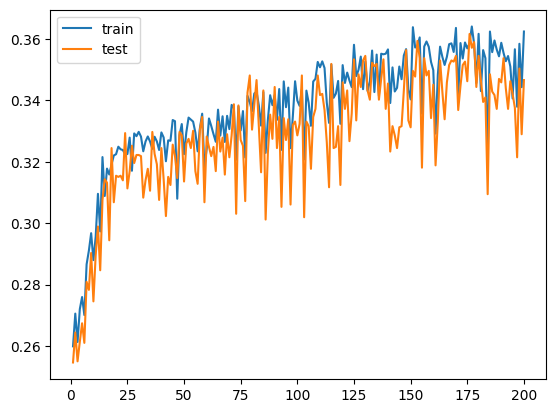

In [48]:
# Plotting
import matplotlib.pyplot as plt
epochs = 200
epoch = [i for i in range(1, epochs+1)]
plt.plot(epoch, train_accuracy, label='train')
plt.plot(epoch, test_accuracy, label='test')
plt.legend()
plt.plot()